In [2]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as pl

mj_ms = 0.0009543
au_rs = 1/215.032
mj_me = 317.8
cg = (ac.G * ac.M_sun / (ac.au.value ** 3)).value * ((60 * 60 * 24) ** 2) / (4*np.pi * np.pi)
hill = lambda mp, ms, a, e: a * (1 - e) * (mp/(3*ms)) ** (1./3.)
t_hill = lambda mp, ms, a, e, P, rs: 2 * (hill(mp, ms, a, e) + rs * au_rs) * P / (2 * np.pi * a)

In [3]:
# read all confirmed planets from the exoplanet archive
from astropy.table import unique

planets = Table.read('../data/planets2.txt', format='csv', comment='#')
period_cut = (planets['pl_orbper'] > 5)
transit = planets['tran_flag'] == 1
targets = planets[period_cut & transit]
targets = unique(targets, keys=['pl_name'], keep='last')
len(targets)

2201

In [4]:
import sys
sys.path.append('../forecaster')
import mr_forecast as mr

mass = np.zeros(len(targets))
masserr1 = np.zeros_like(mass)
masserr2 = np.zeros_like(mass)
for i, p in enumerate(targets):
    if (p['pl_radj'] is np.ma.masked) & (p['pl_rade'] is np.ma.masked):
        mass[i] = -1
        masserr1[i] = -1
        masserr2[i] = -1
    else:
        if p['pl_radj'] is np.ma.masked:
            res = None
            j = 0
            while (res is None) & (j < 10): 
                res = mr.Rstat2M(mean=p['pl_rade'] / 11.2089, std=p['pl_radeerr1'] / 11.2089, unit='Jupiter', sample_size=100, grid_size=100)
                j += 1
        else:
            res = None
            j = 0
            while (res is None) & (j < 10): 
                res = mr.Rstat2M(mean=p['pl_radj'], std=p['pl_radjerr1'], unit='Jupiter', sample_size=100, grid_size=100)
                j += 1
        if res is not None:
            mass[i], masserr1[i], masserr2[i] = res
        else:
            print(p['pl_name'], " ", p['pl_rade'])
            mass[i] = -1
            masserr1[i] = -1
            masserr2[i] = -1

../forecaster/mr_forecast.py:256: RuntimeWarning: divide by zero encountered in true_divide
  radius = truncnorm.rvs( (0.-mean)/std, np.inf, loc=mean, scale=std, size=sample_size)


Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius ran

../forecaster/mr_forecast.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  radius = truncnorm.rvs( (0.-mean)/std, np.inf, loc=mean, scale=std, size=sample_size)


Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius ran

In [5]:
try:
    targets.add_column(np.ma.masked_where(mass == -1, mass * mj_me), name='pl_fmasse')
    targets.add_column(np.ma.masked_where(masserr2 == -1, masserr2 * mj_me), name='pl_fmasseerr1')
    targets.add_column(np.ma.masked_where(masserr1 == -1, masserr1 * mj_me), name='pl_fmasseerr2')
    targets.add_column(np.ma.masked_where(mass == -1, mass), name='pl_fmassj')
    targets.add_column(np.ma.masked_where(masserr2 == -1, masserr2), name='pl_fmassjerr1')
    targets.add_column(np.ma.masked_where(masserr1 == -1, masserr1), name='pl_fmassjerr2')
except ValueError: 
    targets.replace_column('pl_fmasse', np.ma.masked_where(mass == -1, mass * mj_me))
    targets.replace_column('pl_fmasseerr1', np.ma.masked_where(masserr2 == -1, masserr2 * mj_me))
    targets.replace_column('pl_fmasseerr2', np.ma.masked_where(masserr1 == -1, masserr1 * mj_me))
    targets.replace_column('pl_fmassj', np.ma.masked_where(mass == -1, mass))
    targets.replace_column('pl_fmassjerr1', np.ma.masked_where(masserr2 == -1, masserr2))
    targets.replace_column('pl_fmassjerr2', np.ma.masked_where(masserr1 == -1, masserr1))

In [31]:
th = np.zeros(len(targets))
rh = np.zeros_like(th)
rhmax = np.zeros_like(th)
rhmin = np.zeros_like(th)
for i, p in enumerate(targets):
    fmass = p['pl_fmassj']
    fmasserr1 = p['pl_fmassjerr1']
    fmasserr2 = p['pl_fmassjerr2']
    if (p['pl_orbsmax'] is np.ma.masked):
        orbsmax = (cg * (p['pl_orbper'] ** 2) ** (1/3))
    else:
        orbsmax = p['pl_orbsmax']
    if (p['pl_orbeccen'] is np.ma.masked):
        orbeccen = 0
    else:
        orbeccen = p['pl_orbeccen']
    th[i] = 24 * t_hill(fmass * mj_ms, p['st_mass'], 
                     p['pl_orbsmax'], 0.0, 
                     p['pl_orbper'], p['st_rad'])
    rh[i] = hill(fmass * mj_ms, p['st_mass'], orbsmax, orbeccen)
    rhmin[i] = hill((fmass - fmasserr2) * mj_ms, p['st_mass'] + p['st_masserr1'], orbsmax, p['pl_orbeccen'])
    rhmax[i] = hill((fmass + fmasserr1) * mj_ms, p['st_mass'] - p['st_masserr2'], orbsmax, p['pl_orbeccen'])

try:
    targets.add_column(th, name='pl_th_au')
except ValueError:
    targets.replace_column('pl_th_au', th)
try:
    targets.add_column(np.ma.masked_where(~np.isfinite(rh), rh), name='pl_rh_au')
except ValueError:
    targets.replace_column('pl_rh_au', np.ma.masked_where(~np.isfinite(rh), rh))
try:
    targets.add_column(np.ma.masked_where(~np.isfinite(rhmin), rhmin), name='pl_rhmin_au')
except ValueError:
    targets.replace_column('pl_rhmin_au', np.ma.masked_where(~np.isfinite(rhmin), rhmin))
try:
    targets.add_column(np.ma.masked_where(~np.isfinite(rhmax), rhmax), name='pl_rhmax_au')
except ValueError: 
    targets.replace_column('pl_rhmax_au', np.ma.masked_where(~np.isfinite(rhmax), rhmax))

<ipython-input-31-8c5bbf52c0cd>:17: UserWarning: Warning: converting a masked element to nan.
  th[i] = 24 * t_hill(fmass * mj_ms, p['st_mass'],
<ipython-input-2-e531f89f8f78>:9: RuntimeWarning: invalid value encountered in double_scalars
  hill = lambda mp, ms, a, e: a * (1 - e) * (mp/(3*ms)) ** (1./3.)
<ipython-input-31-8c5bbf52c0cd>:20: UserWarning: Warning: converting a masked element to nan.
  rh[i] = hill(fmass * mj_ms, p['st_mass'], orbsmax, orbeccen)
<ipython-input-31-8c5bbf52c0cd>:21: UserWarning: Warning: converting a masked element to nan.
  rhmin[i] = hill((fmass - fmasserr2) * mj_ms, p['st_mass'] + p['st_masserr1'], orbsmax, p['pl_orbeccen'])
<ipython-input-31-8c5bbf52c0cd>:22: UserWarning: Warning: converting a masked element to nan.
  rhmax[i] = hill((fmass + fmasserr1) * mj_ms, p['st_mass'] - p['st_masserr2'], orbsmax, p['pl_orbeccen'])
<ipython-input-2-e531f89f8f78>:9: RuntimeWarning: divide by zero encountered in true_divide
  hill = lambda mp, ms, a, e: a * (1 - e) *

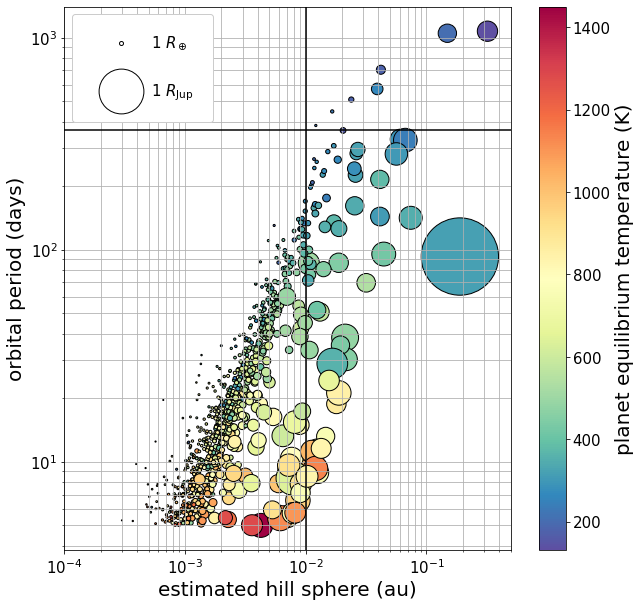

In [73]:
subsample = targets[(targets['st_rad'] < 1.4) & (targets['sy_jmag'] < 14)]
size = (subsample['pl_rade'] * 2) ** 2

pl.figure(figsize=(10, 10))
pl.scatter(subsample['pl_rh_au'], subsample['pl_orbper'], s=size, c=subsample['pl_eqt'], edgecolors='k', 
           linewidths=1, cmap='Spectral_r')
cb = pl.colorbar()
cb.set_label('planet equilibrium temperature (K)', fontsize=20)

pl.yscale('log')
pl.xscale('log')
#pl.xlim(0.001, 0.5)
pl.axvline(0.01, color='k')
pl.axhline(365.25, color='k')
pl.grid(axis='both', which='both')
pl.ylabel(r'orbital period (days)', fontsize=20)
pl.xlabel('estimated hill sphere (au)', fontsize=20)
l1 = pl.scatter([],[], s=(1 * 4) ** 2, edgecolors='k', color='w')
l2 = pl.scatter([],[], s=(5 * 4) ** 2, edgecolors='k', color='w')
l3 = pl.scatter([],[], s=(11.2 * 4) ** 2, edgecolors='k', color='w')

labels = [r'1 $R_\oplus$', r'1 $R_\mathrm{Jup}$']
pl.legend([l1, l3], labels, frameon=True, fontsize=15,
    handlelength=4, loc = 'upper left', borderpad = 1.3,
    handletextpad=0, labelspacing=2, framealpha=1)

pl.xticks(fontsize=15)
pl.yticks(fontsize=15)
cb.ax.tick_params(labelsize=15)
pl.xlim(0.0001, 0.5)
pl.savefig('/Users/tgordon/Desktop/fullsample.pdf')

In [33]:
from astropy.time import Time
import matplotlib.dates as dates
from astropy.table import column

def tobjd(time):
    return Time(time, format='isot', scale='utc').jd

def check_visible(planet, cycle=1, return_times=False):
    if isinstance(p['pl_name'], column.Column):
        name = p['pl_name'].pformat()[2].replace(" ", "")
    else:
        name = p['pl_name'].replace(" ", "")
    windows = np.loadtxt(open('../visibility/{0}.dat'.format(name)).readlines()[9:13], 
                         converters={0: tobjd, 1: tobjd})
    start = windows[:, 0]
    end = windows[:, 1]
    
    vis = np.array([False] * len(start))
    trans_time = p['pl_tranmid']
    per = p['pl_orbper']
    
    while trans_time < end[-1]:
        for i in range(len(start)):
            if (trans_time > start[i]) & (trans_time < end[i]):
                vis[i] = True
        trans_time += per
    if np.any(np.array(cycle) < 1) or np.any(np.array(cycle) > 4):
        raise ValueError("available cycles are (1, 2, 3, 4)")
    return vis[np.array(cycle)-1]

In [36]:
visdict = {}
for p in subsample[(subsample['pl_rh_au'] > 0.005)]:
    try:
        visdict[p['pl_name']] = check_visible(p, cycle=[1, 2, 3, 4])
    except:
        print(p['pl_name'].replace(" ", ""), p['ra'], p['dec'])

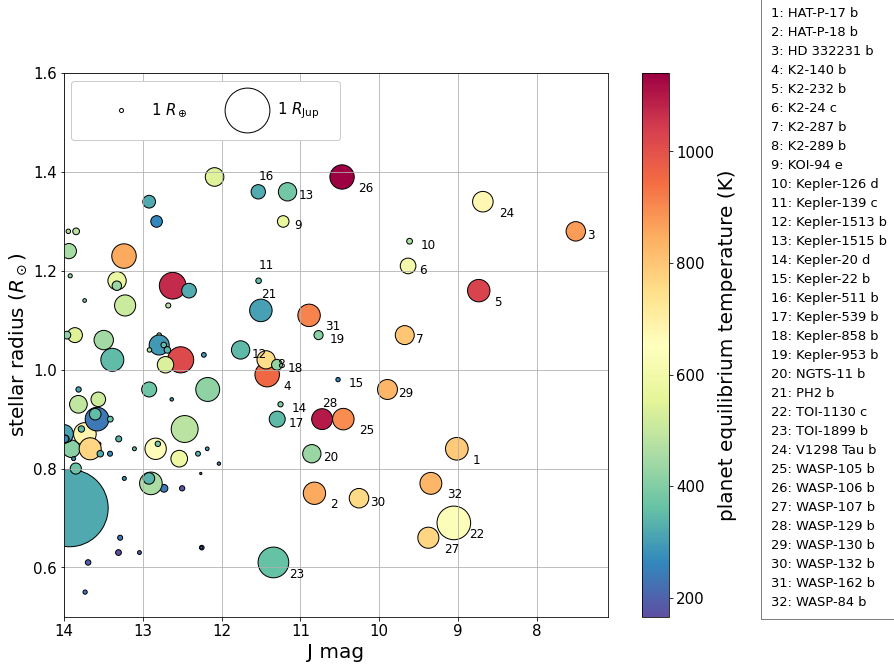

In [37]:
from matplotlib import colors 
subsample = targets[(targets['pl_rh_au'] > 0.007) & (targets['st_rad'] < 1.4) & (targets['sy_jmag'] < 14)]
subsample['allvis'] = [np.all(visdict[s['pl_name']] == True) for s in subsample]
subsample['anyvis'] = [np.any(visdict[s['pl_name']] == True) for s in subsample]
subsample = subsample[subsample['anyvis'] == True]

mint, maxt = np.min(subsample['pl_eqt']), np.max(subsample['pl_eqt'])
size = (subsample['pl_rade'] * 2) ** 2

fig = pl.figure(figsize=(14, 10))
pl.scatter(subsample['sy_jmag'], subsample['st_rad'], 
           c=subsample['pl_eqt'], s=size, edgecolors='k', 
           linewidths=1, cmap='Spectral_r')
cb = pl.colorbar()

annotstr = ""
for i, s in enumerate(subsample[(subsample['sy_jmag'] < 12) & (subsample['cb_flag'] == 0)]):
    if s['pl_rade'] < 10:
        offset = 0.14, 0.015
    else:
        offset = 0.2, 0.03
    if s['pl_name'] not in ['Kepler-16 b', 'HAT-P-15 b', 'WASP-129 b', 'PH2 b', 'HATS-17 b', 'Kepler-511 b', 'Kepler-139 c']:
        annotstr += str(i) + ": " + s['pl_name'] + "\n"
        #pl.annotate(str(i) + ": " + s['pl_name'], xy=(1.3, annoty), xycoords=('axes fraction'), fontsize=15)
        #print(str(i) + ": " + s['pl_name'])
        pl.annotate(i, xy=(s['sy_jmag']-offset[0], s['st_rad']-offset[1]), rotation=0, fontsize=12)
    if s['pl_name'] in ['WASP-129 b', 'PH2 b', 'HATS-17 b', 'Kepler-511 b', 'Kepler-139 c']:
        annotstr += str(i) + ": " + s['pl_name'] + "\n"
        #pl.annotate(str(i) + ": " + s['pl_name'], xy=(1.3, annoty), xycoords=('axes fraction'), fontsize=15)
        #print(str(i) + ": " + s['pl_name'])
        pl.annotate(i, xy=(s['sy_jmag']-0.0, s['st_rad']+0.025), rotation=0, fontsize=12)
pl.annotate(annotstr[:-1], xy=(1.3, 0.02), xycoords="axes fraction", fontsize=13, 
            bbox=dict(fc="white", lw=0.5, pad=10), linespacing=1.6)

l1 = pl.scatter([],[], s=(1 * 4) ** 2, edgecolors='k', color='w')
l2 = pl.scatter([],[], s=(5 * 4) ** 2, edgecolors='k', color='w')
l3 = pl.scatter([],[], s=(11.2 * 4) ** 2, edgecolors='k', color='w')
labels = [r'1 $R_\oplus$', r'1 $R_\mathrm{Jup}$']
pl.legend([l1, l3], labels, ncol=2, frameon=True, fontsize=15,
    handlelength=4, loc = 'upper left', borderpad = 1.3,
    handletextpad=0, labelspacing=2, framealpha=1)

pl.subplots_adjust(right=0.8)
pl.xlim(14, 7.1)
pl.grid(axis='both', which='both')
pl.ylabel(r'stellar radius ($R_\odot$)', fontsize=20)
pl.xlabel('J mag', fontsize=20)
pl.ylim(0.5, 1.6)
cb.set_label('planet equilibrium temperature (K)', fontsize=20)
pl.xticks(fontsize=15)
pl.yticks(fontsize=15)
cb.ax.tick_params(labelsize=15)
pl.savefig('/Users/tgordon/Desktop/targets.pdf')

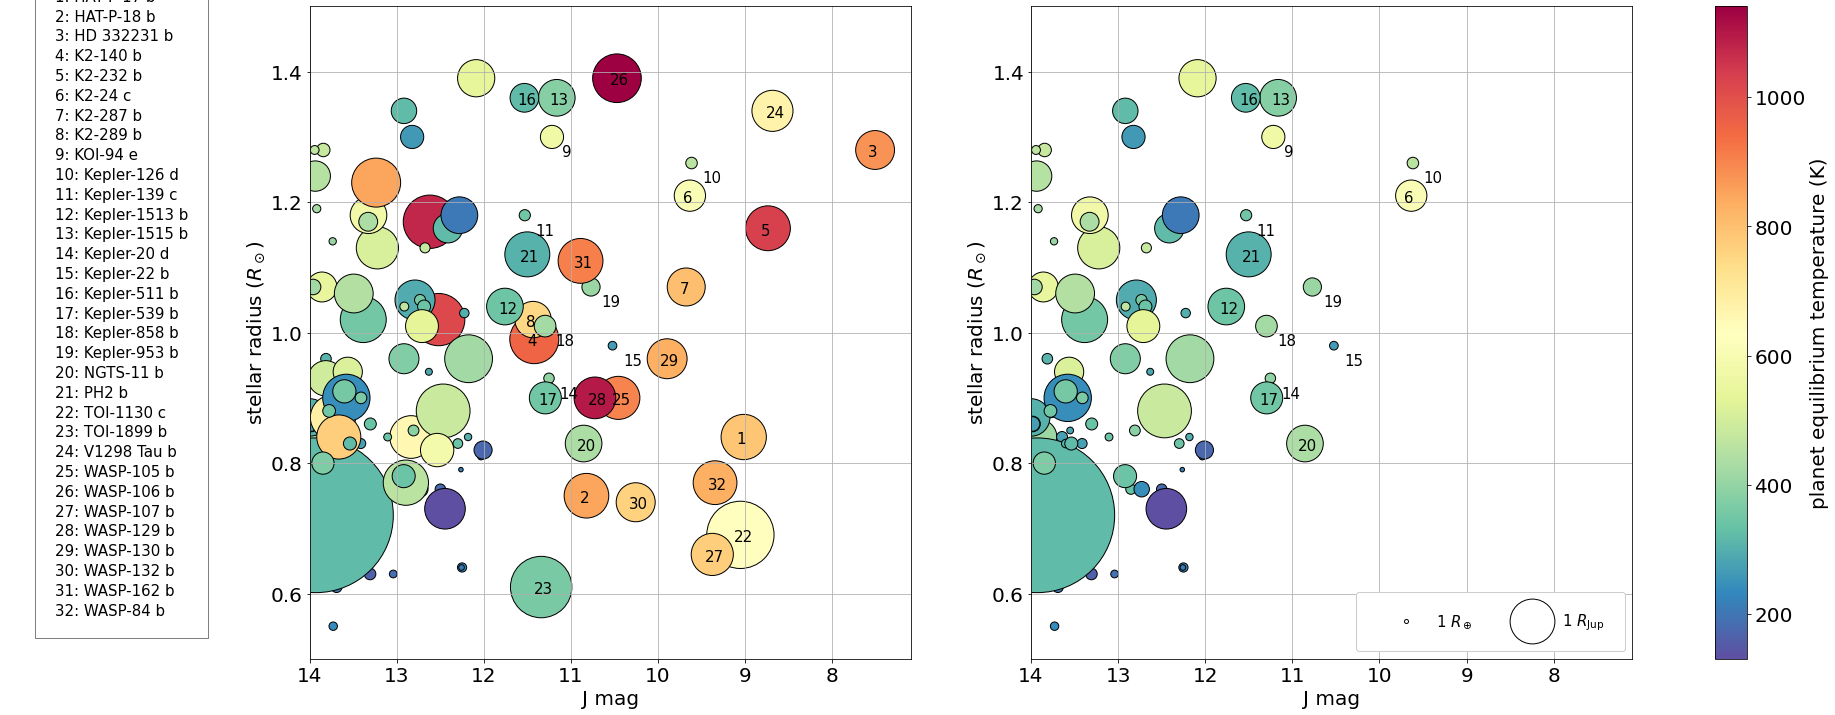

In [39]:
fig, axs = pl.subplots(1, 2, figsize=(28, 12))

import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

subsample = targets[(targets['pl_rh_au'] > 0.007) & (targets['st_rad'] < 1.4) & (targets['sy_jmag'] < 14)]

mint, maxt = np.min(subsample['pl_eqt']), np.max(subsample['pl_eqt'])
size = (subsample['pl_rade'] * 4) ** 2

axs[0].scatter(subsample['sy_jmag'], subsample['st_rad'], 
           c=subsample['pl_eqt'], s=size, edgecolors='k', 
           linewidths=1, cmap='Spectral_r')

annotstr = ""
for i, s in enumerate(subsample[(subsample['sy_jmag'] < 12) & (subsample['cb_flag'] == 0)]):
    if s['pl_rade'] < 7:
        offset = 0.12, 0.03
    else:
        offset = -0.08, 0.01
    if s['pl_name'] not in ['HAT-P-15 b']:
        annotstr += str(i) + ": " + s['pl_name'] + "\n"
        axs[0].annotate(i, xy=(s['sy_jmag']-offset[0], s['st_rad']-offset[1]), rotation=0, fontsize=15)
    if s['pl_name'] in ['']:
        annotstr += str(i) + ": " + s['pl_name'] + "\n"
        axs[0].annotate(i, xy=(s['sy_jmag']-0.0, s['st_rad']+0.025), rotation=0, fontsize=12)
axs[0].annotate(annotstr[:-1], xy=(0.03, 0.14), xycoords="figure fraction", fontsize=15, 
            bbox=dict(fc="white", lw=0.5, pad=20), linespacing=1.4)

axs[0].set_xlim(14, 7.1)
axs[0].grid(axis='both', which='both')
axs[0].set_ylabel(r'stellar radius ($R_\odot$)', fontsize=20)
axs[0].set_xlabel('J mag', fontsize=20)
axs[0].set_ylim(0.5, 1.5)


subsample = targets[(targets['pl_rh_au'] > 0.007) & (targets['st_rad'] < 1.4) & (targets['sy_jmag'] < 14)]
plotsample = subsample[(subsample['pl_orbper'] > 35)]

size = (plotsample['pl_rade'] * 4) ** 2

sc = axs[1].scatter(plotsample['sy_jmag'], plotsample['st_rad'], 
           c=plotsample['pl_eqt'], s=size, edgecolors='k', 
           linewidths=1, cmap='Spectral_r', vmax = maxt)

pl.subplots_adjust(left=0.18, right=1.0)
cb = fig.colorbar(sc, ax=axs.ravel().tolist())
cb.set_label('planet equilibrium temperature (K)', fontsize=20)


for i, s in enumerate(subsample[(subsample['sy_jmag'] < 12) & (subsample['cb_flag'] == 0)]):
    if s['pl_rade'] < 7:
        offset = 0.12, 0.03
    else:
        offset = -0.08, 0.01
    if (s['pl_orbper'] > 35):
        if s['pl_name'] not in ['HAT-P-15 b']:
            axs[1].annotate(i, xy=(s['sy_jmag']-offset[0], s['st_rad']-offset[1]), rotation=0, fontsize=15)
        if s['pl_name'] in ['']:
            axs[1].annotate(i, xy=(s['sy_jmag']-0.0, s['st_rad']+0.025), rotation=0, fontsize=12)

l1 = axs[1].scatter([],[], s=(1 * 4) ** 2, edgecolors='k', color='w')
l2 = axs[1].scatter([],[], s=(5 * 4) ** 2, edgecolors='k', color='w')
l3 = axs[1].scatter([],[], s=(11.2 * 4) ** 2, edgecolors='k', color='w')
labels = [r'1 $R_\oplus$', r'1 $R_\mathrm{Jup}$']
axs[1].legend([l1, l3], labels, ncol=2, frameon=True, fontsize=15,
    handlelength=4, loc = 'lower right', borderpad = 1.3,
    handletextpad=0, labelspacing=2, framealpha=1)

axs[1].set_xlim(14, 7.1)
axs[1].grid(axis='both', which='both')
axs[1].set_ylabel(r'stellar radius ($R_\odot$)', fontsize=20)
axs[1].set_xlabel('J mag', fontsize=20)
axs[1].set_ylim(0.5, 1.5)
pl.savefig('/Users/tgordon/Desktop/targets.pdf')

In [64]:
plotsample[plotsample['pl_name'] == 'Kepler-62 f']['sy_jmag']

12.256


In [63]:
size[[plotsample['pl_name'] == 'Kepler-62 f']]

31.809599999999996


In [991]:
" ".join([str(x) for x in np.where(visdict['V1298 Tau e'])[0] + 1])

'1 3 4'

In [72]:
from astropy.io import ascii
tablesample = targets[(targets['pl_rh_au'] > 0.005) & (targets['st_rad'] < 1.4) & (targets['sy_jmag'] < 13) & (targets['pl_orbper']>35)]
tablecols = tablesample['pl_name', 'sy_jmag', 'st_rad', 'st_teff', 'pl_orbper', 'pl_rade', 'pl_rh_au']
tablecols['vis'] = [" ".join([str(x) for x in np.where(visdict[p])[0] + 1]) for p in tablecols['pl_name']]
tablecols.sort('sy_jmag')
fmtdict = {'pl_rh_au': '%0.3f', 'st_teff': '%d', 'sy_jmag': '%0.3f', 'pl_orbper': "%0.1f", 'pl_rade': '%0.2f'}
ascii.write(tablecols, format='latex', formats=fmtdict)

\begin{table}
\begin{tabular}{cccccccc}
pl_name & sy_jmag & st_rad & st_teff & pl_orbper & pl_rade & pl_rh_au & vis \\
HD 95338 b & 7.099 & 0.87 & 5212 & 55.1 & 3.89 & 0.006 & 1 2 3 4 \\
V1298 Tau e & 8.687 & 1.34 &  & 60.0 & 8.74 & 0.007 & 1 3 4 \\
Kepler-126 d & 9.616 & 1.26 & 6164 & 100.3 & 2.89 & 0.009 & 1 2 3 4 \\
K2-24 c & 9.635 & 1.21 & 5743 & 42.4 & 7.82 & 0.009 & 1 2 3 4 \\
Kepler-16 b & 9.815 & 0.65 & 4450 & 228.8 & 8.45 & 0.037 & 1 2 3 4 \\
Kepler-538 b & 10.026 & 0.87 & 5451 & 81.7 & 2.29 & 0.007 & 1 2 3 4 \\
Kepler-22 b & 10.523 & 0.98 & 5642 & 289.9 & 2.17 & 0.015 & 1 3 4 \\
Kepler-953 b & 10.770 & 1.07 & 5611 & 88.4 & 4.55 & 0.010 & 1 2 3 4 \\
NGTS-11 b & 10.855 & 0.83 & 5050 & 35.5 & 9.16 & 0.019 & 1 2 3 4 \\
Kepler-517 b & 11.020 & 1.06 & 5598 & 60.9 & 2.87 & 0.007 & 1 2 3 4 \\
Kepler-1515 b & 11.163 & 1.36 & 6471 & 214.3 & 9.17 & 0.041 & 1 2 3 4 \\
KOI-94 e & 11.218 & 1.3 & 6098 & 54.3 & 5.79 & 0.009 & 1 2 3 4 \\
Kepler-20 d & 11.252 & 0.93 & 5465 & 77.6 & 2.62 & 0.00

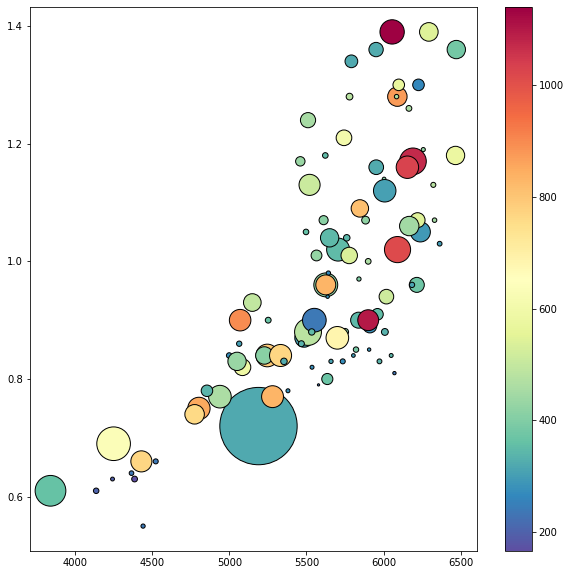

In [815]:
pl.figure(figsize=(10, 10))
pl.scatter(subsample['st_teff'], subsample['st_rad'], 
           c=subsample['pl_eqt'], s=size, edgecolors='k', 
           linewidths=1, cmap='Spectral_r')
cb = pl.colorbar()

10.953